# Coli Toolkit (CTK) Flow Cytometry Analysis and Model Calibration

## User Setup

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import FlowCal as fcs
import os
from scipy.stats import gaussian_kde
import shutil
import warnings

### Data Source Setup
Here you can link the directories containing the respective data.

In [2]:
data_dir = "data/"
for rep_dir in os.listdir(data_dir):
    rep_dir_path = os.path.join(data_dir, rep_dir)
    if not os.path.isdir(rep_dir_path):
        continue    
    if not rep_dir.startswith("replicate"):
        continue
    
    for const_dir in os.listdir(rep_dir_path):
        const_dir_path = os.path.join(rep_dir_path, const_dir)
        if not os.path.isdir(const_dir_path):
            continue   

        target_dir = os.path.join(data_dir, const_dir, rep_dir)
        os.makedirs(target_dir, exist_ok=True)
        for file in os.listdir(const_dir_path):
            file_path = os.path.join(const_dir_path, file)
            if not os.path.isfile(file_path):
                continue

            target_file_path = os.path.join(target_dir, file)
            shutil.copyfile(file_path, target_file_path)
            print(f"Copied {file_path} to {target_file_path}")
            
    

Copied data/replicate 1\basal\DH10B 0uM.fcs to data/basal\replicate 1\DH10B 0uM.fcs
Copied data/replicate 1\basal\DH10B 1000uM.fcs to data/basal\replicate 1\DH10B 1000uM.fcs
Copied data/replicate 1\basal\DH10B 100uM.fcs to data/basal\replicate 1\DH10B 100uM.fcs
Copied data/replicate 1\basal\DH10B 10uM.fcs to data/basal\replicate 1\DH10B 10uM.fcs
Copied data/replicate 1\basal\DH10B 150uM.fcs to data/basal\replicate 1\DH10B 150uM.fcs
Copied data/replicate 1\basal\DH10B 200uM.fcs to data/basal\replicate 1\DH10B 200uM.fcs
Copied data/replicate 1\basal\DH10B 20uM.fcs to data/basal\replicate 1\DH10B 20uM.fcs
Copied data/replicate 1\basal\DH10B 30uM.fcs to data/basal\replicate 1\DH10B 30uM.fcs
Copied data/replicate 1\basal\DH10B 40uM.fcs to data/basal\replicate 1\DH10B 40uM.fcs
Copied data/replicate 1\basal\DH10B 50uM.fcs to data/basal\replicate 1\DH10B 50uM.fcs
Copied data/replicate 1\basal\DH10B 5uM.fcs to data/basal\replicate 1\DH10B 5uM.fcs
Copied data/replicate 1\basal\DH10B 70uM.fcs to 

In [3]:
data_dir_constitutive = "data/constitutive/"
data_dir_inputs = "data/inputs/"
data_dir_gates = "data/gates/"
data_dir_reference = "data/reference/"
data_dir_basal = "data/basal/"
data_dir_inputs_cross_reactivity = "data/inputs_cross_reactivity/"


## Figure Output Setup

In [4]:
figure_dir = "figures/"
figure_extension = ".pdf"

os.makedirs(figure_dir, exist_ok=True)

### General Setup

In [5]:
reference_promoter = "J23101"                                           # The constitutive reference promoter which serves as baseline for the RPU conversion
alternative_reference_promoter_name = {"J23101": "pJCM434"}             # Currently, the reference promoter is part of the dataset in two different names
inducer_units = {"ind1": "pgul", "ind2": "uM", "ind3": "uM"}
inducer_molecule_type = {"pJCM435": "IPTG", "pJCM448": "Ara", "pJCM449": "aTc"}
controlling_input_sensor = "pJCM435"                                    # The input sensor used for the characterization of the gate plasmids
facs_channel = "FL1-A"                                                  # The fluorescence FACS channel we are interested in
p_gating = 0.95                                                         # The probability mass to preserve after gating
gating_channels = ["FSC-A", "FSC-H"]                                    # The two channels to apply gating on
kde_bandwith = 0.05                                                     # Bandwith of gaussian kernel density estimate

## Model Calibration Setup

In [6]:
n_walkers = 10
n_chains = 10
n_samples = 10000

### Figures Setup

In [7]:
lim = (10**(-3), 10**2)
histogram_bins = np.logspace(np.log10(lim[0]), np.log10(lim[1]), 200)                
hist_as_density = False                                                # Whether to turn the histogram into a valid density (sum over width x height = 1) or not
plot_as_density = False                                                 # Whether to use kernel density estimate instead of histograms for representing distributions

input_sensor_order = ["Ptac", "PBAD", "Ptet"]
inducer_order = ["No", "IPTG", "Ara", "aTc"]
present_top_k = 5                                                      # Number of top gates to present according to dynamic range

In [8]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family': 'serif',
        'serif': ['Helvetica'],
        'size': 8}

savefig = {'bbox': 'tight',
           'pad_inches': 0.01,
           'dpi': 1200,
           'transparent': True}

matplotlib.rc('font', **font)
matplotlib.rc('savefig', **savefig)
mm_to_inch = lambda val: np.array(val) * 0.0393701

In [9]:
COLORS = [(0.30, 0.56, 1.00), (0.35, 0.24, 1.00), (1.00, 0.00, 0.42), (1.00, 0.40, 0.10), (1.00, 0.65, 0.19)]
COLORS_DARK = [(0.00, 0.24, 0.90), (0.28, 0.00, 0.84), (0.80, 0.00, 0.27), (0.90, 0.24, 0.00), (1.00, 0.50, 0.00)]
COLORS_MAIN = [(0.30, 0.55, 1.00), (1.00, 0.40, 0.10)]
COLORS_CMAP_ORANGE = ["#FFFFFF", "#FF5500", "#B3003C"]
COLORS_CMAP_BLUE = ["#FFFFFF", "#69A3FF", "#4400D6"]

COLORMAP_ORANGE = LinearSegmentedColormap.from_list("my_cmap", COLORS_CMAP_ORANGE)
COLORMAP_BLUE = LinearSegmentedColormap.from_list("my_cmap", COLORS_CMAP_BLUE)

COLOR_GRAY = "#808080"
COLOR_REPLICATES = COLORS_DARK[2:] # Use only redish colors for replicates

## Definition of Utility Functions

In [10]:
def list_facs_files(directory):
    replicate_directories = os.listdir(directory)                    # Gets all the elements in data_dir and stores them as list in files 

    relevant_files = []                             # Target list to store the relevant files in
    for rep_dir in replicate_directories:
        rep_dir_path = os.path.join(directory, rep_dir)
        if not os.path.isdir(rep_dir_path):
            continue
            
        files = os.listdir(rep_dir_path)
        # We here filter for .fcs files and store them in relevant_files        
        for file in files:
            if os.path.splitext(file)[-1] != ".fcs":    # Exclude not .fcs files            
                continue
            relevant_files.append(os.path.join(rep_dir_path, file))                 # Adds file to the list of relevant files
            # break
    return relevant_files

def merge_replicates(replicates_data):
    # Compare replicates via median values and discard whole dataset in case the replicates deviation is too large.    
    merged_data = None
    num_replicates = len(replicates_data)

    if num_replicates < 1:
        return merged_data
        
    num_levels = len(replicates_data[0])

    merged_data = [None] * num_levels
    merged_info = [None] * num_levels
    for iL in range(num_levels):
        dist_mat = np.zeros(shape=(num_replicates, num_replicates))
        print("Merge", iL, list(map(np.median, [replicate[iL] for replicate in replicates_data])))
        replicate_lengths = np.array([len(replicate[iL]) for replicate in replicates_data])
        replicates_to_consider = replicate_lengths >= 1000     # Require at least 1000 samples
        
        for iR1 in range(num_replicates):            
            rep_val_1 = np.median(replicates_data[iR1][iL])            
            for iR2 in range(num_replicates):
                if iR2 < iR1:
                    continue
                    
                rep_val_2 = np.median(replicates_data[iR2][iL])
                dist_mat[iR1, iR2] = rep_val_1 / rep_val_2
                dist_mat[iR2, iR1] = dist_mat[iR1, iR2]
        
        relative_distances = np.abs(np.log2(dist_mat))
        vals = np.triu(relative_distances, k=1)
        threshold = 3
        mask = relative_distances <= threshold
        use_replicates = np.all(mask[replicates_to_consider][:, replicates_to_consider])      # Only consider replicates with sufficient read counts
        indices_to_consider = np.logical_and(replicates_to_consider, use_replicates)
        
            
        print("Merge", iL, indices_to_consider)
        cur_data = [replicates_data[iR][iL] for iR, flag in enumerate(indices_to_consider) if flag]
        if len(cur_data) > 0:
            merged_data[iL] = np.concatenate(cur_data)
        else:
            merged_data[iL] = np.array([])
        merged_info[iL] = indices_to_consider
    return merged_data, merged_info
                
    

def transform_data_dict(data_dict, construct_inducer_units={}):
    for construct_id in data_dict:
        print(construct_id)
        replicates = {}
        for replicate_id in data_dict[construct_id]:
            cur_data = data_dict[construct_id][replicate_id]
            replicate_inducer_unit = ""
            replicate_inducer_molecule = ""
            if construct_id in construct_inducer_units:
                replicate_inducer_unit = construct_inducer_units[construct_id]["unit"]
                replicate_inducer_molecule = construct_inducer_units[construct_id]["molecule"]
                
            replicate_inducer_concentrations = list(cur_data.keys())
            replicate_inducer_concentrations = sorted(replicate_inducer_concentrations)            
            
            fcs_datasets = [cur_data[conc] for conc in replicate_inducer_concentrations]
            replicate_data = [fcs_data[:, facs_channel] for fcs_data in fcs_datasets]
            replicates[replicate_id] = {"inducer unit": replicate_inducer_unit,
                                        "inducer molecule": replicate_inducer_molecule,
                                        "inducer concentrations": replicate_inducer_concentrations, 
                                        "data": replicate_data}

        replicate_inducer_units = [replicates[rep_id]["inducer unit"] for rep_id in replicates]
        replicate_inducer_molecules = [replicates[rep_id]["inducer molecule"] for rep_id in replicates]
        if len(set(replicate_inducer_units)) > 1:
            raise Exception("Replicates have different inducer units")
        if len(set(replicate_inducer_molecules)) > 1:
            raise Exception("Replicates have different inducer molecules")
            
        inducer_unit = replicate_inducer_units[0]
        inducer_molecule = replicate_inducer_molecules[0]

        replicate_inducer_concentrations = [replicates[rep_id]["inducer concentrations"] for rep_id in replicates]
        if not all([elem == replicate_inducer_concentrations[0] for elem in replicate_inducer_concentrations]):
            raise Exception("Not all replicates have the same inducer concentrations")
        
        inducer_concentrations = replicate_inducer_concentrations[0]

        replicates_data = [replicates[rep_id]["data"] for rep_id in replicates]
        merged_data, merged_info = merge_replicates(replicates_data)        
        data = merged_data
        
        data_dict[construct_id] = {"inducer unit": inducer_unit,
                                   "inducer molecule": inducer_molecule,
                                   "inducer concentrations": inducer_concentrations,
                                   "data unit": "AU",
                                   "data": data,
                                   "replicates merge info": merged_info, 
                                   "replicates": replicates}

def load_constitutive_data(file_paths):
    data_dict = {}             # Dictionary for storing the data with the inducer level as key
    for path in file_paths:                                              # Iterate over the facs files
        facs_data = fcs.io.FCSData(path)                                 # Use library to load facs data    
        facs_data = fcs.gate.density2d(facs_data,                        # Gate facs data
                                           channels=gating_channels,
                                           gate_fraction=p_gating)       
        # Extract and parse file name
        replicate_id = os.path.basename(os.path.split(path)[0])
        filename = os.path.basename(path)
        name, ext = os.path.splitext(filename)
        if not name in data_dict:
            data_dict[name] = {}
        data_dict[name][replicate_id] = {np.nan: facs_data}
        print(f"Loaded data for `{name}` ({replicate_id})")


    transform_data_dict(data_dict)
    return data_dict


def load_inducible_data(file_paths):
    
    data_dict = {}             # Dictionary for storing the data with the inducer level as key
    construct_inducer_units = {}
    
    for path in file_paths:                                              # Iterate over the facs files
        facs_data = fcs.io.FCSData(path)                                 # Use library to load facs data    
        facs_data = fcs.gate.density2d(facs_data,                        # Gate facs data
                                           channels=gating_channels,
                                           gate_fraction=p_gating)
        
        # Extract and parse file name
        replicate_id = os.path.basename(os.path.split(path)[0])
        filename = os.path.basename(path)
        name, ext = os.path.splitext(filename)
    
        # Extract and parse file name
        # Exemplary content of filename: pJCM435 0uM.fcs
        # Format is: "[construct_id] [inducer_level][inducer_unit].fcs"
        construct_id, inducer_description = name.split(" ")
        
        inducer_unit = None        
        for unit in inducer_units.values():      
            
            if unit in inducer_description:
                inducer_unit = unit
        if inducer_unit is None:
            raise Exception(f"Unknow inducer unit in {inducer_description}")
    
        inducer_concentration = float(inducer_description.replace(inducer_unit, ""))
        
        if not construct_id in data_dict:
            data_dict[construct_id] = {}
            construct_inducer_units[construct_id] = {"molecule": inducer_molecule_type[construct_id] if construct_id in inducer_molecule_type else "", 
                                                     "unit": inducer_unit}
            
        if not replicate_id in data_dict[construct_id]:
            data_dict[construct_id][replicate_id] = {}
        
        data_dict[construct_id][replicate_id][inducer_concentration] = facs_data
        
        print(f"Loaded data for construct `{construct_id}` and inducer concentration {inducer_concentration} {inducer_unit} ({replicate_id})")
    
    
    transform_data_dict(data_dict, construct_inducer_units)
    return data_dict


## Load and Gate Data

### Load Constitutive Data

In [11]:
# We here infer the inducer concentration from the file names and load the facs data

file_paths = list_facs_files(data_dir_constitutive)
file_paths = sorted(file_paths)
# file_paths = [path for path in file_paths if "J23107" in path]   # Exemplary code for loading data of a single construt only

data_constitutive = load_constitutive_data(file_paths)
rpu_reference_data = data_constitutive[reference_promoter + "-No"]["data"]

Loaded data for `J23101-Ara` (replicate 1)
Loaded data for `J23101-IPTG` (replicate 1)
Loaded data for `J23101-No` (replicate 1)
Loaded data for `J23101-aTc` (replicate 1)
Loaded data for `J23102-Ara` (replicate 1)
Loaded data for `J23102-IPTG` (replicate 1)
Loaded data for `J23102-No` (replicate 1)
Loaded data for `J23102-aTc` (replicate 1)
Loaded data for `J23103-Ara` (replicate 1)
Loaded data for `J23103-IPTG` (replicate 1)
Loaded data for `J23103-No` (replicate 1)
Loaded data for `J23103-aTc` (replicate 1)
Loaded data for `J23104-Ara` (replicate 1)
Loaded data for `J23104-IPTG` (replicate 1)
Loaded data for `J23104-No` (replicate 1)
Loaded data for `J23104-aTc` (replicate 1)
Loaded data for `J23105-Ara` (replicate 1)
Loaded data for `J23105-IPTG` (replicate 1)
Loaded data for `J23105-No` (replicate 1)
Loaded data for `J23105-aTc` (replicate 1)
Loaded data for `J23106-Ara` (replicate 1)
Loaded data for `J23106-IPTG` (replicate 1)
Loaded data for `J23106-No` (replicate 1)
Loaded data

C:\Users\Alexandros\AppData\Local\Temp\ipykernel_7072\3350500338.py:47: RuntimeWarning: invalid value encountered in log2
  relative_distances = np.abs(np.log2(dist_mat))


J23110-No
Merge 0 [np.float32(6525.45), np.float32(5607.7), np.float32(10152.1)]
Merge 0 [ True  True  True]
J23110-aTc
Merge 0 [np.float32(6448.25), np.float32(6652.65), np.float32(10655.1)]
Merge 0 [ True  True  True]
J23111-Ara
Merge 0 [np.float32(57753.95), np.float32(59415.85), np.float32(93904.35)]
Merge 0 [ True  True  True]
J23111-IPTG
Merge 0 [np.float32(58905.2), np.float32(59390.25), np.float32(95953.9)]
Merge 0 [ True  True  True]
J23111-No
Merge 0 [np.float32(59220.15), np.float32(59661.65), np.float32(95619.7)]
Merge 0 [ True  True  True]
J23111-aTc
Merge 0 [np.float32(60912.2), np.float32(65501.7), np.float32(99372.1)]
Merge 0 [ True  True  True]
J23113-Ara
Merge 0 [np.float32(3942.2998), np.float32(3701.6), np.float32(6741.5)]
Merge 0 [ True  True  True]
J23113-IPTG
Merge 0 [np.float32(4010.3), np.float32(3544.5), np.float32(6891.5)]
Merge 0 [ True  True  True]
J23113-No
Merge 0 [np.float32(4214.05), np.float32(3770.25), np.float32(7163.7)]
Merge 0 [ True  True  True]
J

### Load Input Data

In [12]:
# We here infer the inducer concentration from the file names and load the facs data

file_paths = list_facs_files(data_dir_inputs)
file_paths = sorted(file_paths)

data_inputs = load_inducible_data(file_paths)

Loaded data for construct `pJCM435` and inducer concentration 0.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 1000.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 100.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 10.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 150.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 200.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 20.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 30.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 40.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 50.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 5.0 uM (replicate 1)
Loaded data for construct `pJCM435` and inducer concentration 70.0 uM (re

### Load Gate Data

In [13]:
file_paths = list_facs_files(data_dir_gates)
file_paths = sorted(file_paths)
# file_paths = [path for path in file_paths if "pJCM212" in path] # Exemplary code for loading data of a single gate construct

data_gates = load_inducible_data(file_paths)

Loaded data for construct `pJCM212` and inducer concentration 0.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 1000.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 100.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 10.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 150.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 200.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 20.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 30.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 40.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 50.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 5.0 uM (replicate 1)
Loaded data for construct `pJCM212` and inducer concentration 70.0 uM (re

### Load Reference Data

In [14]:
# We here infer the inducer concentration from the file names and load the facs data

file_paths = list_facs_files(data_dir_reference)
file_paths = sorted(file_paths)

data_reference = load_inducible_data(file_paths)
ref_name = alternative_reference_promoter_name[reference_promoter]

Loaded data for construct `pJCM434` and inducer concentration 0.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 1000.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 100.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 10.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 150.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 200.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 20.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 30.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 40.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 50.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 5.0 uM (replicate 1)
Loaded data for construct `pJCM434` and inducer concentration 70.0 uM (re

### Load Autofluorescence Data

In [15]:
file_paths = list_facs_files(data_dir_basal)
file_paths = sorted(file_paths)

data_basal = load_inducible_data(file_paths)
autofluorescence_reference_data = np.concatenate((data_basal["DH10B"]["data"])) # Use data from all inducer concentrations as reference

Loaded data for construct `DH10B` and inducer concentration 0.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 1000.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 100.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 10.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 150.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 200.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 20.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 30.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 40.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 50.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 5.0 uM (replicate 1)
Loaded data for construct `DH10B` and inducer concentration 70.0 uM (replicate 1)
Loaded data f

### Load Input Cross Reactivitiy Data

In [16]:
# We here infer the inducer concentration from the file names and load the facs data

file_paths = list_facs_files(data_dir_inputs_cross_reactivity)
file_paths = sorted(file_paths)

data_inputs_cross_reactivity = load_constitutive_data(file_paths)

Loaded data for `DH10B-Ara` (replicate 1)
Loaded data for `DH10B-IPTG` (replicate 1)
Loaded data for `DH10B-No` (replicate 1)
Loaded data for `DH10B-aTc` (replicate 1)
Loaded data for `PBAD-Ara` (replicate 1)
Loaded data for `PBAD-IPTG` (replicate 1)
Loaded data for `PBAD-No` (replicate 1)
Loaded data for `PBAD-aTc` (replicate 1)
Loaded data for `Ptac-Ara` (replicate 1)
Loaded data for `Ptac-IPTG` (replicate 1)
Loaded data for `Ptac-No` (replicate 1)
Loaded data for `Ptac-aTc` (replicate 1)
Loaded data for `Ptet-Ara` (replicate 1)
Loaded data for `Ptet-IPTG` (replicate 1)
Loaded data for `Ptet-No` (replicate 1)
Loaded data for `Ptet-aTc` (replicate 1)
Loaded data for `PBAD-Ara` (replicate 2)
Loaded data for `PBAD-IPTG` (replicate 2)
Loaded data for `PBAD-No` (replicate 2)
Loaded data for `PBAD-aTc` (replicate 2)
Loaded data for `Ptac-Ara` (replicate 2)
Loaded data for `Ptac-IPTG` (replicate 2)
Loaded data for `Ptac-No` (replicate 2)
Loaded data for `Ptac-aTc` (replicate 2)
Loaded data 

## Normalize Data to RPU

Equation for the scaling factor $c$ used to rescale the fluorescence values into RPU.

\begin{align*}
c = \frac{\bar{FP} - \bar{FP}_0}{\bar{FP}} \, \frac{1}{\bar{FP}_{RPU} - \bar{FP}_0}
\end{align*}

In particular, $\bar{FP}$ is the median fluorescence of the expression values under consideration. $\bar{FP}_0$ is the median autofluorescence and $\bar{FP}_{RPU}$ is the median fluorescence of the reference plasmid.

In [17]:
def transform_to_RPU(data_dict, rpu_reference_data, autofluorescence_reference_data):
    def rpu_transform(data, FP_0, FP_RPU):
        output_data = [None] * len(data)
        for iX in range(len(data)):
            FP = np.median(data[iX])
            
            c = (FP - FP_0)/FP * 1 / (FP_RPU - FP_0)
            
            output_data[iX]= data[iX] * c        
        return output_data
        
    FP_RPU = np.median(rpu_reference_data)
    FP_0 = np.median(autofluorescence_reference_data)
    # print(FP_RPU)
    for construct_id in data_dict:
        cur_entry = data_dict[construct_id]
  
            
        data = cur_entry["data"]        
        cur_entry["output"] = rpu_transform(data, FP_0, FP_RPU)
        if "replicates" in cur_entry:
            for replicate_id in cur_entry["replicates"]:
                data =  cur_entry["replicates"][replicate_id]["data"]        
                cur_entry["replicates"][replicate_id]["output"] = rpu_transform(data, FP_0, FP_RPU)

        

In [18]:
transform_to_RPU(data_constitutive, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_inputs, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_gates, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_reference, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_basal, rpu_reference_data, autofluorescence_reference_data)
transform_to_RPU(data_inputs_cross_reactivity, rpu_reference_data, autofluorescence_reference_data)

C:\Users\Alexandros\AppData\Local\Temp\ipykernel_7072\1068965255.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  output_data[iX]= data[iX] * c
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Insert Inducer RPU into Controlled Constructs
In particular, the median RPU of the input sensor used for characterizing is added to the controlled constructs data as second input reference. The original inducer concentration will be preserved.

In [19]:
def insert_input_rpu(data_dict, input_data):
    median_input_RPU = [np.median(elem) for elem in input_data["output"]]
    for construct_id in data_dict:
        data_dict[construct_id]["input RPU"] = median_input_RPU  
        # Theoretically, one could assign the RPU histograms instead of the median value.
        # However, the combined data wouldn't represent actuall joint data as the data has been generated in two separate experiments.

In [20]:
input_data = data_inputs[controlling_input_sensor]

insert_input_rpu(data_gates, input_data=input_data)

# Model Calibration
For the model calibration, we use the inhibitory Hill equation as model for the response curve and Parallel Tempering, a Markov chain Monte Carlo algorithm, for parameter sampling and optimization.

In [21]:
from tqdm import tqdm

class OptimizationAlgorithm:

    def __init__(self):
        pass


    def run(self):
        raise Exception("Needs to be implemented by sub class")

class ParallelTempering(OptimizationAlgorithm):

    def __init__(self, log_likelihood, log_prior, n_dim, n_walkers=1, n_chains=10):
        self.log_likelihood = log_likelihood
        self.log_prior = log_prior
        self.n_dim = n_dim

        self.n_walkers = n_walkers
        self.n_chains = n_chains

        swap_mask = np.zeros(shape=(n_walkers, int(np.ceil(n_chains / 2) * 2)), dtype=bool)
        swap_mask[:, ::2] = 1
        self.swap_mask = swap_mask
        pass

    def run(self, initial_parameters, n_samples=10 ** 3, target_acceptance_ratio=None,
            adaptive_temperature=True):

        n_walkers = self.n_walkers
        n_chains = self.n_chains

        initial_parameters = np.array(initial_parameters)
        self.temperatures = np.power(2, np.arange(self.n_chains), dtype=float)

        if adaptive_temperature and n_chains <= 2:
            print(
                f"Disabling adaptive temperature for n_chains={n_chains}. Minimal number of chains for adaptive temperature is 3, but more chains are recommended.")
            adaptive_temperature = False

        if adaptive_temperature:
            self.temperatures[-1] = np.inf
            # Value choice follows Vousden et al. 2016
            v_factor = 10 ** 2
            v = int(np.ceil(v_factor / n_walkers))
            t0 = 10 * v  
            S = np.log(np.diff(self.temperatures, axis=-1))
            S = S[:-1]
            # Diffs of T_2 - T_1, ..., T_(N-1) - T_(N-2). The diff T_N - T_(N-1) is excluded by purpose following 1 < i < N for the S_i

        variance = 0.1
        self.variance = np.ones(shape=(self.n_walkers, self.n_chains, self.n_dim))
        self.variance = self.variance * np.expand_dims(np.expand_dims(np.arange(1, self.n_chains + 1), axis=0),
                                                       axis=-1)
        self.variance *= variance

        adaptive_proposal_distribution = target_acceptance_ratio is not None and target_acceptance_ratio > 0 and target_acceptance_ratio < 1.0

        adaptive_temperature_stop_iteration = int(n_samples / 2)

        parameters = np.zeros(shape=(n_samples, n_walkers, n_chains, *initial_parameters.shape))
        priors = np.zeros(shape=(n_samples, n_walkers, n_chains))
        likelihoods = np.zeros(shape=(n_samples, n_walkers, n_chains))
        step_accepts = np.zeros(shape=(n_samples, n_walkers, n_chains))
        swap_accepts = []

        params = np.array(initial_parameters)
        likelihood = self.log_likelihood(params)
        prior = self.log_prior(params)
        # max_iN = 0
        for iN in tqdm(range(n_samples)):
            self.beta = 1 / np.expand_dims(self.temperatures, axis=0)

            params, prior, likelihood, step_accept = self.step(params, prior, likelihood, index=iN)
            swap_round = iN % 10 == 9
            if swap_round:
                params, prior, likelihood, swap_accept = self.swap(params, prior, likelihood, index=iN)
                swap_accepts.append(swap_accept)

            parameters[iN] = params
            priors[iN] = prior
            likelihoods[iN] = likelihood
            step_accepts[iN] = step_accept

            ##################################
            # Adaptive Proposal Distribution #
            ##################################
            if adaptive_proposal_distribution and iN >= 100 and iN % 10 == 0:
                # Considers Windowed average of the last 100 steps
                acc_rate_deviation = step_accepts[max(iN - 100 + 1, 0):iN + 1] - target_acceptance_ratio
                scaling_params = np.exp((np.mean(acc_rate_deviation, axis=0)))
                self.variance = self.variance * np.expand_dims(scaling_params, axis=-1)

            ###############################
            # Adaptive Temperature Ladder #
            ###############################

            if adaptive_temperature and swap_round and iN > 20 and iN < adaptive_temperature_stop_iteration:
                kappa = 1 / v * t0 / (iN + t0)
                # Be aware that only every 10th iteration is a swap iteration
                rel_accepts = swap_accepts[max(len(swap_accepts) - 100, 0):]  # Select relevant data
                swap_acceptance_rate = np.mean(rel_accepts, axis=0)  # Average over multiple samples
                swap_acceptance_rate = np.mean(swap_acceptance_rate, axis=0)  # Average over multiple walkers
                swap_rate_diff = -np.diff(swap_acceptance_rate, axis=0)  # Compute the diff over the chains
                S = S + kappa * swap_rate_diff
                temp_diffs = self.temperatures
                temp_diffs[1:-1] = np.exp(S)
                self.temperatures = np.cumsum(temp_diffs)

        parameters = np.array(parameters)
        priors = np.array(priors)
        likelihoods = np.array(likelihoods)
        step_accepts = np.array(step_accepts)
        swap_accepts = np.array(swap_accepts)
        return parameters, priors, likelihoods, step_accepts, swap_accepts

    def step(self, params, prior, likelihood, index):
        move = np.random.normal(loc=0, scale=self.variance)
        proposal = params + move

        proposal_likelihood = self.log_likelihood(proposal)
        proposal_prior = self.log_prior(proposal)
        proposal_prob = self.beta * proposal_likelihood + proposal_prior

        prob = self.beta * likelihood + prior

        log_diff = proposal_prob - prob
        diff = np.exp(log_diff)
        u = np.random.uniform(size=(self.n_walkers, self.n_chains))
        accept = u < diff

        new_prior = np.where(accept, proposal_prior, prior)
        new_likelihood = np.where(accept, proposal_likelihood, likelihood)

        params_accepts = np.expand_dims(accept, -1)
        new_params = np.where(params_accepts, proposal, params)
        return new_params, new_prior, new_likelihood, accept

    def swap(self, params, prior, likelihood, index):
        log_diff = np.diff(likelihood, axis=-1)
        beta_diff = -np.diff(self.beta, axis=-1)

        log_criterion = beta_diff * log_diff
        criterion = np.exp(log_criterion)
        u = np.random.uniform(size=(self.n_walkers, self.n_chains - 1))
        # Ensure in the accepts step that a single chain does not swap to both adjacent chains (it should be possible to check this by using np.diff(accept) which should not yield 0 at a position including a 1 in accept
        proposed_accept = u < criterion
        self.swap_mask = np.roll(self.swap_mask, 1)
        swap_mask = self.swap_mask[:, :self.n_chains - 1]
        accept = np.logical_and(proposed_accept, swap_mask)
        # accept[:, i] defines whether to swap between chain i and i+1.

        # swap_matrice_1 is accept matrice with an additional all zeros entry
        swap_matrice_1 = np.concatenate((accept, np.zeros((self.n_walkers, 1))), axis=1)
        swap_matrice_2 = np.roll(swap_matrice_1, 1, axis=1)

        left_rolled_prior = np.roll(prior, -1, axis=1)
        right_rolled_prior = np.roll(prior, 1, axis=1)
        left_rolled_likelihood = np.roll(likelihood, -1, axis=1)
        right_rolled_likelihood = np.roll(likelihood, 1, axis=1)
        left_rolled_params = np.roll(params, -1, axis=1)
        right_rolled_params = np.roll(params, 1, axis=1)

        new_prior = np.where(swap_matrice_1, left_rolled_prior, prior)
        new_prior = np.where(swap_matrice_2, right_rolled_prior, new_prior)
        new_likelihood = np.where(swap_matrice_1, left_rolled_likelihood, likelihood)
        new_likelihood = np.where(swap_matrice_2, right_rolled_likelihood, new_likelihood)
        new_params = np.where(np.expand_dims(swap_matrice_1, -1), left_rolled_params, params)
        new_params = np.where(np.expand_dims(swap_matrice_2, -1), right_rolled_params, new_params)

        return new_params, new_prior, new_likelihood, accept


In [22]:
class RandomSampling(OptimizationAlgorithm):

    def __init__(self, loss_func):
        self.loss_func = loss_func


    def run(self, repetitions, initial_parameters, parameter_lower_bounds, parameter_upper_bounds):
        
        initial_parameters = np.array(initial_parameters)
        parameter_lower_bounds = np.array(parameter_lower_bounds)
        parameter_upper_bounds = np.array(parameter_upper_bounds)

        assert initial_parameters.shape == parameter_upper_bounds.shape and parameter_upper_bounds.shape == parameter_lower_bounds.shape

        shape = initial_parameters.shape
        best_solution = None
        best_score = np.inf

        bounds_diff = parameter_upper_bounds - parameter_lower_bounds

        for _ in tqdm(range(repetitions)):

            new_proposal = np.random.uniform(low=0, high=1, size=shape)
            new_proposal = parameter_lower_bounds + (new_proposal * (bounds_diff))

            score = self.loss_func(new_proposal)

            if score <= best_score:
                best_solution = new_proposal
                best_score = score
        
        return best_solution, best_score



In [23]:
from scipy.optimize import minimize
class ScipyOptimization(OptimizationAlgorithm):

    def __init__(self, loss_func):
        self.loss_func = loss_func


    def run(self, initial_parameters, method="powell", bounds=None, tol=10 ** (-10), options = {}):

        result = minimize(self.loss_func, x0 = initial_parameters, method=method, tol = tol, bounds=bounds, options=options)
        return result


In [24]:
class EvolutionaryOptimization(OptimizationAlgorithm):

    def __init__(self, loss_func):
        self.loss_func = loss_func

        self.known_implementations = ["random"]

    def run(self, parameter_lower_bounds, parameter_upper_bounds, groups = 10, group_size = 100, generations = 100, steps_per_generation=50, replacement_amount = 50, variance = 1, replacement_mode = "random"):
        
        shape = (groups, group_size, len(parameter_lower_bounds))
        #init generations
        generation_lower_bounds = np.tile(np.array(parameter_lower_bounds).reshape((1,1,len(parameter_lower_bounds))), (groups, group_size, 1))
        generation_upper_bounds = np.tile(np.array(parameter_upper_bounds).reshape((1,1,len(parameter_upper_bounds))), (groups, group_size, 1))

        generation_bounds_diff = generation_upper_bounds - generation_lower_bounds
        generation_params = generation_lower_bounds + (np.random.uniform(low=0, high=1,size=(groups, group_size, len(parameter_lower_bounds))) * generation_bounds_diff)

        #init generation scores
        generation_score = np.apply_along_axis(self.loss_func, axis=2, arr=generation_params)

        for _ in tqdm(range(generations)):
            
            #params anpassen
            for _ in range(steps_per_generation):
            
                #Erstelle werte von 0.9-1.1 die dann als skalierungswert für die parameter verwendet werden
                #multiplcative_values = np.clip(np.random.normal(loc=1.0, scale=variance, size=shape), a_min=0.9, a_max=1.1)
                #generation_proposal = generation_params * multiplcative_values

                move = np.random.normal(loc=0, scale=variance, size=shape)
                generation_proposal = generation_params + move
                
                #berechne improvment aus neuen param vorschlag. differenz zwischen neuen und alten score. Wenn diff > 0 dann neuer score niedriger
                proposal_score = np.apply_along_axis(self.loss_func, axis=2, arr=generation_proposal)
                improvments = generation_score-proposal_score
                mask = (improvments > 0)

                #Ersetze alle elemente, wo der neue vorschlag besser war
                generation_params[mask] = generation_proposal[mask]
                generation_score[mask] = proposal_score[mask]
            
            #finde die parameter mit dem höchsten score
            generation_replace_indices = np.argpartition(a=generation_score, axis=1, kth=replacement_amount)

            

            #gehe alle gruppen durch
            for group in range(groups):
                group_replace_indices = generation_replace_indices[group][replacement_amount+1:]
                
                possible_fill_in_indices = None

                #case das mode "random" die indexe zum ersetzen auswählt
                if replacement_mode == "random":
                    possible_fill_in_indices = np.setdiff1d(ar1=np.arange(start=0, stop=group_size, step=1), ar2=group_replace_indices)
                
                else:
                    raise NotImplementedError(f"This replacement method is not implemented. Implemented are {self.known_implementations}!")
                
                for replace_index in group_replace_indices:
                    fill_in_index = np.random.choice(a=possible_fill_in_indices)
                    generation_params[group][replace_index] = generation_params[group][fill_in_index]
                    generation_score[group][replace_index] = generation_score[group][fill_in_index]
        
        minimal_index = np.argmin(a=generation_score)
        shaped_minimal_index = np.unravel_index(minimal_index, generation_score.shape)

        return generation_params[shaped_minimal_index[0]][shaped_minimal_index[1]], generation_score[shaped_minimal_index[0]][shaped_minimal_index[1]]

        


## Define Models

In [25]:
def activatory_hill_equation(x, params):
    ymax, ymin, n, k = params
    y = ymin + (ymax - ymin) / (1 + np.power(k/x, n))
    return y

def inhibitory_hill_equation(x, params):
    ymax, ymin, n, k = params
    y = ymin + (ymax - ymin) / (1 + np.power(x/k, n))
    return y

## Define Loss Function Generator

In [26]:
def get_loss_function(model, data):
    def loss_function(params):
        X, Y_true = data
        losses = []
        model_params = np.exp(params)        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            Y_pred = model(X, model_params)        
        diffs = np.log(Y_pred) - np.log(Y_true)         
        
        losses = np.power(diffs, 2)  
        nan_mask = np.logical_not(np.isnan(losses))
        loss = np.sum(losses[nan_mask])        
        
        return loss
        

    return loss_function

In [27]:
np.seterr(all='ignore')

for construct_id in data_inputs:    
        
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]


    data = inducer_concentration, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    #Hillkurve initialparameter
    init_params = (min_Y_true, max_Y_true, 2, 1)
    params_lower_bounds = (min_Y_true * 10**(-1), max_Y_true * 10**(-1), 10**(-1), 10**(-1))
    params_upper_bounds = (min_Y_true * 10**(1), max_Y_true * 10**(1), 10**(1), 10**(1))
    

    loss_func = get_loss_function(model=activatory_hill_equation, data=data)
    
    
    
    so = RandomSampling(loss_func=loss_func)
    parameters, score = so.run(repetitions=2*10**6, initial_parameters=init_params, parameter_lower_bounds=params_lower_bounds, parameter_upper_bounds=params_upper_bounds)

    print(f"{construct_id=};{parameters=};{score=}")

    

100%|██████████| 2000000/2000000 [00:20<00:00, 99192.10it/s] 
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


construct_id='pJCM435';parameters=array([2.59748828e-03, 2.44925931e-01, 2.63521423e+00, 5.24028682e-01]);score=np.float64(80.09093888817)


100%|██████████| 2000000/2000000 [00:20<00:00, 96557.54it/s] 


construct_id='pJCM448';parameters=array([1.57276551e-03, 1.26699953e-01, 2.03049294e+00, 1.13755877e+00]);score=np.float64(103.43273762430466)


100%|██████████| 2000000/2000000 [00:20<00:00, 99943.54it/s] 

construct_id='pJCM449';parameters=array([0.32242265, 0.95104988, 9.25869426, 8.79984097]);score=np.float64(44.568718017973445)


In [28]:
for construct_id in data_inputs:    
        
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]


    data = inducer_concentration, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    #Hillkurve initialparameter
    init_params = (min_Y_true, max_Y_true, 2, 1)

    loss_func = get_loss_function(model=activatory_hill_equation, data=data)

    max_fev_per_param = 500

    tol=10 ** (-10)
    options={"disp": True,
            "ftol": 10 ** (-7),
            "maxfev": len(init_params) * max_fev_per_param,
            "disp":False
            }
    
    so = ScipyOptimization(loss_func=loss_func)
    result= so.run(initial_parameters=init_params, tol=tol, options=options)
    print(f"{construct_id=};parameters={result['x']}; score={result['fun']}")


c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


construct_id='pJCM435';parameters=[ 1.04072049 -4.25076434  0.57369969  5.57278845]; score=0.16793472764725131
construct_id='pJCM448';parameters=[ 3.96883717e-03 -4.19679609e+00  8.97674860e-01  6.29704002e+00]; score=0.5231497991774883
construct_id='pJCM449';parameters=[ 2.13970688 -3.45092084  0.76589444  2.2808888 ]; score=0.17412373597830855


In [29]:
for construct_id in data_inputs:    
        
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]


    data = inducer_concentration, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    #Hillkurve initialparameter
    init_params = (min_Y_true, max_Y_true, 2, 1)
    params_lower_bounds = (min_Y_true * 10**(-1), max_Y_true * 10**(-1), 10**(-1), 10**(-1))
    params_upper_bounds = (min_Y_true * 10**(1), max_Y_true * 10**(1), 10**(1), 10**(1))
    

    loss_func = get_loss_function(model=activatory_hill_equation, data=data)
    
    
    
    eo = EvolutionaryOptimization(loss_func=loss_func)

    groups = 2
    group_size = 30
    generations = 300
    steps_per_generation = 100
    replacement_amount = 5
    variance = 0.001
    params, score = eo.run(parameter_lower_bounds=params_lower_bounds, parameter_upper_bounds=params_upper_bounds,
                    groups=groups, group_size=group_size, generations=generations, steps_per_generation=steps_per_generation, replacement_amount=replacement_amount, variance=variance, replacement_mode="random")
    
    print(f"{construct_id=}; {params=}; {score=}")

    #print(f"{construct_id=}; {parameters=}; {score=}")

100%|██████████| 300/300 [00:15<00:00, 18.86it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


construct_id='pJCM435'; params=array([ 0.36331469, -3.09512034,  2.06659453,  4.51143721]); score=np.float64(6.0788399696370385)


100%|██████████| 300/300 [00:16<00:00, 17.81it/s]


construct_id='pJCM448'; params=array([ 0.22763042, -3.04903346,  5.92325019,  7.31182672]); score=np.float64(18.532863100557943)


100%|██████████| 300/300 [00:15<00:00, 19.12it/s]

construct_id='pJCM449'; params=array([ 2.13974932, -3.45089134,  0.76588976,  2.28092871]); score=np.float64(0.1741237440662486)


## Fit Inputs

In [30]:
for construct_id in data_inputs:    
        
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]


    data = inducer_concentration, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    init_params = (min_Y_true, max_Y_true, 2, 1)
    

    loss_func = get_loss_function(model=activatory_hill_equation, data=data)
    

    def log_prior(params):
        # Define more precise prior for y_max and y_min with a broad distribution (y_max, y_max * 2). Check how proxies for n and k can be inferred directly from data

        a_min=np.log([max_Y_true, min_Y_true / 2, 10**(-20), 10**(-20)])
        a_max=np.log([max_Y_true * 2, min_Y_true, 10**10, 10**10])
        l_prior = - np.power(params - np.clip(params, a_min=a_min, a_max=a_max), 2) / 1
        l_prior = np.sum(l_prior, axis=-1)    
        
        return l_prior        
    
    def log_likelihood(params):    
        # Vectorization of loss function
        if len(params.shape) == 1:
            return -loss_func(params)
        else:
            log_likelihood_vals = np.empty(shape=params.shape[:2])
            for i1 in range(params.shape[0]):
               for i2 in range(params.shape[1]):
                   log_likelihood_vals[i1, i2] = -loss_func(params[i1, i2]) / 1
                
            return log_likelihood_vals
    
    
    
    pt = ParallelTempering(log_likelihood=log_likelihood, log_prior=log_prior, n_dim=len(init_params), 
                           n_walkers=n_walkers,
                           n_chains=n_chains)
    parameters, priors, likelihoods, step_accepts, swap_accepts = pt.run(initial_parameters=np.log(init_params), n_samples=n_samples,
                                                                             target_acceptance_ratio=0.4,
                                                                             adaptive_temperature=True)
    best_index = np.unravel_index(np.argmax(priors + likelihoods), likelihoods.shape)
    params = np.exp(parameters[*best_index])

    best_loss = loss_func(np.log(params))
    # ymax, ymin, n, k
    params_dict = {"y_max": params[0],
                   "y_min": params[1],
                   "n": params[2],
                   "k": params[3]}
    data_inputs[construct_id]["model information"] = {"model type": "ACTIVATORY HILL EQUATION",
                                                     "calibration loss": best_loss,
                                                     "parameters" : params_dict}
    print(f"{construct_id}; parameters={params_dict}; score={best_loss}")
    
    
    # params = init_params

100%|██████████| 10000/10000 [00:08<00:00, 1170.27it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


pJCM435; parameters={'y_max': np.float64(2.9144133112463706), 'y_min': np.float64(0.014396640980493267), 'n': np.float64(1.749744575457283), 'k': np.float64(272.1530529414105)}; score=0.17126927818310123


100%|██████████| 10000/10000 [00:08<00:00, 1125.00it/s]


pJCM448; parameters={'y_max': np.float64(1.1128796648308925), 'y_min': np.float64(0.013777094124303323), 'n': np.float64(2.207065969507792), 'k': np.float64(626.3546289224685)}; score=0.551550400330385


100%|██████████| 10000/10000 [00:08<00:00, 1172.96it/s]

pJCM449; parameters={'y_max': np.float64(8.577286462645771), 'y_min': np.float64(0.031060335600280604), 'n': np.float64(2.150563057458151), 'k': np.float64(9.920785323291906)}; score=0.1761927458620939


## Fit Outputs

In [31]:
for construct_id in data_gates:
    cur_data = data_gates[construct_id]
    input_RPU = cur_data["input RPU"]
    output_RPU = cur_data["output"]   


    data = input_RPU, list(map(lambda elem: np.median(elem), output_RPU))
    X, Y_true = data
    min_Y_true = np.nanmin(Y_true)
    max_Y_true = np.nanmax(Y_true)
    
    init_params = (max_Y_true, min_Y_true, 2, 0.01)
    

    loss_func = get_loss_function(model=inhibitory_hill_equation, data=data)
    

    def log_prior(params):
        # Define more precise prior for y_max and y_min with a broad distribution (y_max, y_max * 2). Check how proxies for n and k can be inferred directly from data

        a_min=np.log([max_Y_true, min_Y_true / 2, 10**(-20), 10**(-20)])
        a_max=np.log([max_Y_true * 2, min_Y_true, 10**10, 10**10])
        l_prior = - np.power(params - np.clip(params, a_min=a_min, a_max=a_max), 2) / 1
        l_prior = np.sum(l_prior, axis=-1)    
        
        return l_prior        
    
    def log_likelihood(params):    
        # Vectorization of loss function
        if len(params.shape) == 1:
            return -loss_func(params)
        else:
            log_likelihood_vals = np.empty(shape=params.shape[:2])
            for i1 in range(params.shape[0]):
               for i2 in range(params.shape[1]):
                   log_likelihood_vals[i1, i2] = -loss_func(params[i1, i2]) / 1
                
            return log_likelihood_vals
    
    
    
    
    pt = ParallelTempering(log_likelihood=log_likelihood, log_prior=log_prior, n_dim=len(init_params), 
                           n_walkers=n_walkers,
                           n_chains=n_chains)
    parameters, priors, likelihoods, step_accepts, swap_accepts = pt.run(initial_parameters=np.log(init_params), n_samples=n_samples,
                                                                             target_acceptance_ratio=0.4,
                                                                             adaptive_temperature=True)
    best_index = np.unravel_index(np.argmax(priors + likelihoods), likelihoods.shape)
    params = np.exp(parameters[*best_index])
    print(f"{params=}")

    best_loss = loss_func(np.log(params))
    # ymax, ymin, n, k
    params_dict = {"y_max": params[0],
                   "y_min": params[1],
                   "n": params[2],
                   "k": params[3]}
    data_gates[construct_id]["model information"] = {"model type": "INHIBITORY HILL EQUATION",
                                                     "calibration loss": best_loss,
                                                     "parameters" : params_dict}
    print(f"Fitted parameters for gate {construct_id} with loss {best_loss} ({params_dict})")
        

100%|██████████| 10000/10000 [00:08<00:00, 1137.73it/s]


params=array([4.90855392, 0.04302285, 1.91907211, 0.01183949])
Fitted parameters for gate pJCM212 with loss 0.2283945653050934 ({'y_max': np.float64(4.908553918009922), 'y_min': np.float64(0.043022849966688315), 'n': np.float64(1.919072108250684), 'k': np.float64(0.01183949244584872)})


100%|██████████| 10000/10000 [00:08<00:00, 1133.41it/s]


params=array([0.52885724, 0.00468867, 2.39660055, 0.00929872])
Fitted parameters for gate pJCM213 with loss 0.534235059712205 ({'y_max': np.float64(0.5288572371447622), 'y_min': np.float64(0.004688671133109927), 'n': np.float64(2.3966005454992136), 'k': np.float64(0.009298715769149474)})


100%|██████████| 10000/10000 [00:08<00:00, 1145.11it/s]


params=array([0.33786296, 0.02553393, 1.51257715, 0.07201573])
Fitted parameters for gate pJCM214 with loss 0.09070341087785969 ({'y_max': np.float64(0.3378629567382374), 'y_min': np.float64(0.025533928297438405), 'n': np.float64(1.5125771511676298), 'k': np.float64(0.07201573443436582)})


100%|██████████| 10000/10000 [00:08<00:00, 1143.27it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


params=array([0.36592145, 0.07607067, 0.74354392, 1.01460036])
Fitted parameters for gate pJCM215 with loss 0.025311966298399515 ({'y_max': np.float64(0.3659214541850106), 'y_min': np.float64(0.07607066606832313), 'n': np.float64(0.7435439176981734), 'k': np.float64(1.0146003624691424)})


100%|██████████| 10000/10000 [00:09<00:00, 1096.98it/s]


params=array([9.71053445, 0.11503493, 1.98812201, 0.05978454])
Fitted parameters for gate pJCM216 with loss 0.15165518492404914 ({'y_max': np.float64(9.71053444520054), 'y_min': np.float64(0.11503493045238944), 'n': np.float64(1.9881220102571588), 'k': np.float64(0.05978453884935612)})


100%|██████████| 10000/10000 [00:08<00:00, 1147.79it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


params=array([4.90671243, 0.43495103, 1.39261435, 0.08796341])
Fitted parameters for gate pJCM217 with loss 0.04476229018999725 ({'y_max': np.float64(4.906712425834471), 'y_min': np.float64(0.4349510303403445), 'n': np.float64(1.3926143549882475), 'k': np.float64(0.08796340706744962)})


100%|██████████| 10000/10000 [00:09<00:00, 1100.91it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


params=array([5.04000035, 0.10503005, 1.71401976, 0.08900637])
Fitted parameters for gate pJCM218 with loss 0.1209992295450752 ({'y_max': np.float64(5.0400003503680155), 'y_min': np.float64(0.10503004509456242), 'n': np.float64(1.7140197577936493), 'k': np.float64(0.08900636920131541)})


100%|██████████| 10000/10000 [00:09<00:00, 1094.44it/s]


params=array([4.79929627, 0.09855395, 2.69030486, 0.03104684])
Fitted parameters for gate pJCM219 with loss 0.2651766689964668 ({'y_max': np.float64(4.799296273004141), 'y_min': np.float64(0.09855394598534269), 'n': np.float64(2.6903048614390106), 'k': np.float64(0.031046841363381615)})


100%|██████████| 10000/10000 [00:08<00:00, 1147.92it/s]


params=array([0.36449742, 0.00948512, 1.2919972 , 0.02461113])
Fitted parameters for gate pJCM220 with loss 0.07902733543921624 ({'y_max': np.float64(0.36449742255962325), 'y_min': np.float64(0.009485123538689693), 'n': np.float64(1.2919971989583439), 'k': np.float64(0.02461113322770446)})


100%|██████████| 10000/10000 [00:08<00:00, 1145.84it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


params=array([1.22314614, 0.0207807 , 1.45099336, 0.03735208])
Fitted parameters for gate pJCM221 with loss 0.05712140810142799 ({'y_max': np.float64(1.2231461369439827), 'y_min': np.float64(0.020780703041388352), 'n': np.float64(1.4509933632834058), 'k': np.float64(0.03735208371983361)})


100%|██████████| 10000/10000 [00:09<00:00, 1094.46it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


params=array([7.28187033, 0.04769703, 3.06704334, 0.03911093])
Fitted parameters for gate pJCM222 with loss 0.11118420712069316 ({'y_max': np.float64(7.281870328244074), 'y_min': np.float64(0.04769703267493378), 'n': np.float64(3.0670433444881513), 'k': np.float64(0.03911093119318926)})


100%|██████████| 10000/10000 [00:09<00:00, 1098.05it/s]
c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


params=array([7.87694365, 0.05627437, 2.32866286, 0.10697816])
Fitted parameters for gate pJCM223 with loss 0.1107243826861474 ({'y_max': np.float64(7.87694365477983), 'y_min': np.float64(0.05627437489909303), 'n': np.float64(2.3286628587589093), 'k': np.float64(0.1069781626675845)})


100%|██████████| 10000/10000 [00:09<00:00, 1091.31it/s]


params=array([8.58374533, 0.05873458, 2.54278336, 0.04433697])
Fitted parameters for gate pJCM224 with loss 0.07744164967197772 ({'y_max': np.float64(8.583745329088892), 'y_min': np.float64(0.058734577731139846), 'n': np.float64(2.542783360515949), 'k': np.float64(0.044336965007517756)})


100%|██████████| 10000/10000 [00:08<00:00, 1150.84it/s]


params=array([9.141242  , 0.04709729, 2.37859286, 0.02111717])
Fitted parameters for gate pJCM225 with loss 0.047201246817758606 ({'y_max': np.float64(9.141242002038029), 'y_min': np.float64(0.04709728793123809), 'n': np.float64(2.3785928635773943), 'k': np.float64(0.021117172401110246)})


100%|██████████| 10000/10000 [00:08<00:00, 1140.66it/s]


params=array([8.26973117, 0.04418132, 1.62185021, 0.05568987])
Fitted parameters for gate pJCM226 with loss 0.1117483192713867 ({'y_max': np.float64(8.269731169797655), 'y_min': np.float64(0.044181317864178546), 'n': np.float64(1.6218502076255723), 'k': np.float64(0.05568986973249767)})


100%|██████████| 10000/10000 [00:08<00:00, 1133.60it/s]


params=array([7.49864109, 0.1628297 , 1.08160949, 0.07514295])
Fitted parameters for gate pJCM227 with loss 0.0334121571967426 ({'y_max': np.float64(7.498641085107938), 'y_min': np.float64(0.16282970392768645), 'n': np.float64(1.0816094893796369), 'k': np.float64(0.0751429476015947)})


100%|██████████| 10000/10000 [00:09<00:00, 1093.96it/s]


params=array([0.87947795, 0.00479496, 3.9887411 , 0.01112972])
Fitted parameters for gate pJCM228 with loss 0.5762369679056305 ({'y_max': np.float64(0.8794779527611688), 'y_min': np.float64(0.004794963017562467), 'n': np.float64(3.988741104360776), 'k': np.float64(0.011129721310001272)})


100%|██████████| 10000/10000 [00:08<00:00, 1138.67it/s]


params=array([1.94718794, 0.01134642, 2.50495899, 0.02655458])
Fitted parameters for gate pJCM229 with loss 0.022586937905716552 ({'y_max': np.float64(1.9471879400547092), 'y_min': np.float64(0.011346418093698294), 'n': np.float64(2.5049589942809485), 'k': np.float64(0.026554584709830756)})


100%|██████████| 10000/10000 [00:08<00:00, 1153.46it/s]


params=array([1.89607145, 0.01189278, 1.69178412, 0.04816301])
Fitted parameters for gate pJCM230 with loss 0.07421425313431448 ({'y_max': np.float64(1.896071445779591), 'y_min': np.float64(0.011892775346773557), 'n': np.float64(1.6917841212981775), 'k': np.float64(0.04816300685666554)})


100%|██████████| 10000/10000 [00:08<00:00, 1152.79it/s]

params=array([1.7805401 , 0.01058554, 2.27673781, 0.05205621])
Fitted parameters for gate pJCM231 with loss 0.14992520167979542 ({'y_max': np.float64(1.7805401012339364), 'y_min': np.float64(0.010585543389351255), 'n': np.float64(2.276737806629326), 'k': np.float64(0.05205621441435661)})


In [32]:
# Code to visualize statistics of parallel tempering
if False:
    from numpy.lib.stride_tricks import sliding_window_view
    step_accepts_sliding_window = np.transpose(sliding_window_view(step_accepts[:, :, :], 100, axis=0),
                                               axes=(0, 3, 1, 2))
    step_accepts_avg = np.mean(step_accepts_sliding_window, axis=1)
    
    swap_accepts_sliding_window = np.transpose(sliding_window_view(swap_accepts, 10, axis=0), axes=(0, 3, 1, 2))
    swap_accepts_avg = np.mean(swap_accepts_sliding_window, axis=1)
    
    for iWalker in range(n_walkers):
        fig, axes = plt.subplots(ncols=2)
    
        for iChain in range(step_accepts_avg.shape[-1]):
            axes[0].plot(np.arange(2) * (len(step_accepts_avg) - 1),
                         np.ones(2) * 0.4 + (n_chains - iChain - 1), "k--", alpha=0.5)
            axes[0].plot(np.arange(len(step_accepts_avg)),
                         step_accepts_avg[:, iWalker, iChain] + (n_chains - iChain - 1), label=iChain, alpha=1)
    
        for iChain in range(swap_accepts_avg.shape[-1]):
            axes[1].plot(np.arange(2) * (len(swap_accepts_avg) - 1), np.ones(2) * 0 + (n_chains - iChain - 1), "r--",
                         alpha=0.5)
            axes[1].plot(np.arange(len(swap_accepts_avg)),
                         swap_accepts_avg[:, iWalker, iChain] + (n_chains - iChain - 1), label=iChain, alpha=1)
    
        ylim = axes[0].get_ylim()
        axes[1].set_ylim(ylim)
        axes[0].legend()
        axes[1].legend()
        plt.show()

# Visualize Data

## Visualize Constitutive Promoters

In [33]:
key_median_pairs = [(key, np.median(data_constitutive[key]["output"])) for key in data_constitutive]
key_median_pairs = sorted(key_median_pairs, key=lambda elem: elem[1], reverse=False)
key_median_pairs = [elem[0] for elem in key_median_pairs]

input_device_keys = [key.split("-")[0] for key in key_median_pairs if "No" in key]
inducer_keys = [key.split("-")[1] for key in key_median_pairs]

input_device_keys = input_device_keys
inducer_keys = [elem for elem in inducer_order if elem in inducer_keys]

data = []
for iRow, input_device_key in enumerate(input_device_keys):
    cur_data = []
    for iCols, inducer_key in enumerate(inducer_keys):
        cur_data.append(data_constitutive[f"{input_device_key}-{inducer_key}"])
    data.append(cur_data)

data = np.array(data)

### Constitutive Promoters Comparison

In [34]:
data_to_plot = list(map(lambda elem: elem["output"], data[:, 0]))

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: He

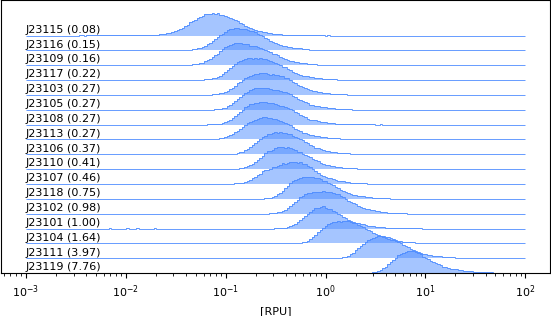

In [35]:
figsize = (180, 90)
fig, ax = plt.subplots(figsize=mm_to_inch(figsize))

length = len(input_device_keys)
color = COLORS_MAIN[0]

for iR in range(length):
    input_device = input_device_keys[length - iR - 1]
    cur_data = data_to_plot[length - iR - 1][0]

    if plot_as_density and True:            
        kde = gaussian_kde(cur_data, bw_method=kde_bandwith)
        kde_vals = kde( )
        kde_vals = kde_vals / np.max(kde_vals) * 0.75
        ax.plot(histogram_bins, kde_vals + iR, color=color)
        ax.fill_between(histogram_bins, np.ones(shape=histogram_bins.shape) * iR, kde_vals + iR, color=color, alpha=0.5)
    else:
        hist, bins = np.histogram(cur_data, bins=histogram_bins)
        hist = hist  / np.max(hist) * 1.5
        ax.bar(bins[:-1], hist, np.diff(histogram_bins), color=color, alpha=0.5, align="edge", bottom=iR)    
        # ax.plot(bins, np.ones(len(bins)) * iR, color=color) 
        ax.plot(np.repeat(bins, 2)[1:-1], np.repeat(hist, 2) + iR, linewidth=0.6, color=color, solid_capstyle='butt', solid_joinstyle="miter") 
        
    
    
    ax.text(bins[0], iR + 0.1, f"{input_device} ({np.median(cur_data):.2f})", va='bottom', ha='left')#, fontsize=10)

    ax.set_xlabel("[RPU]")
    ax.set_yticks([])
    

# ax.plot(np.flip(list(map(np.median, data_to_plot))), range(length), color=COLORS_MAIN[0])
    

ax.set_xscale("log")
plt.savefig(f"{figure_dir}/constitutive_promoters_histograms{figure_extension}")
plt.show()


### Constitutive Promoters Cross Reactivity

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

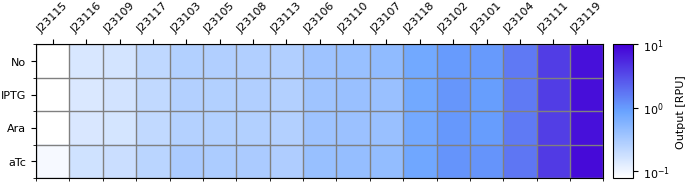

In [36]:
data_to_plot = np.zeros(shape=data.shape)
for iRow in range(data.shape[0]):
    for iCol in range(data.shape[1]):
        data_to_plot[iRow, iCol] = np.median(data[iRow, iCol]["output"])

data_to_plot = data_to_plot.transpose()

fig_size = np.array([180, 90])
fig_size = mm_to_inch(fig_size)
fig, ax = plt.subplots(figsize=fig_size)
im = ax.imshow(data_to_plot, cmap=COLORMAP_BLUE, interpolation="none", origin="upper", rasterized=True, norm=matplotlib.colors.SymLogNorm(vmax=10**1, linthresh=0.001))


x_ticks = np.arange(data_to_plot.shape[1])
y_ticks = np.arange(data_to_plot.shape[0])
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels(input_device_keys,rotation=45)
ax.set_yticklabels(inducer_keys)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax.set_xticks(np.arange(data_to_plot.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(data_to_plot.shape[0] + 1) - 0.5, minor=True)
ax.grid(which="minor", color="#808080", linestyle='-', linewidth=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=0.2, pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Output [RPU]")
cbar.set_ticks([10**(-1), 10**0, 10**1])


plt.tight_layout()
plt.savefig(f"{figure_dir}/constitutive_promoter_cross_reactivity{figure_extension}")
plt.show()

### Save data to table

In [37]:
table_rep = []

header = ["Device"] + inducer_keys[:1]
table_rep.append(header)

length = len(input_device_keys)
for iR in range(length):
    input_device = input_device_keys[iR]
    row_vals = [input_device]
    # for iC in range(data.shape[1]):
        # cur_data = data[iR][iC]
    cur_data = data[iR][0]
    cur_val = np.median(cur_data["output"][0])
    row_vals.append(f"{cur_val:.4f}")
    table_rep.append(row_vals)
    
    
table_str = "\n".join([", ".join(row) for row in table_rep])
print(table_rep)
with open("figures/constitutive_promoters_cross_reactivity.csv", "w") as file:
    file.write(table_str)

[['Device', 'No'], ['J23115', '0.0791'], ['J23116', '0.1479'], ['J23109', '0.1586'], ['J23117', '0.2173'], ['J23103', '0.2675'], ['J23105', '0.2726'], ['J23108', '0.2728'], ['J23113', '0.2736'], ['J23106', '0.3703'], ['J23110', '0.4076'], ['J23107', '0.4635'], ['J23118', '0.7461'], ['J23102', '0.9776'], ['J23101', '1.0000'], ['J23104', '1.6368'], ['J23111', '3.9726'], ['J23119', '7.7601']]


findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

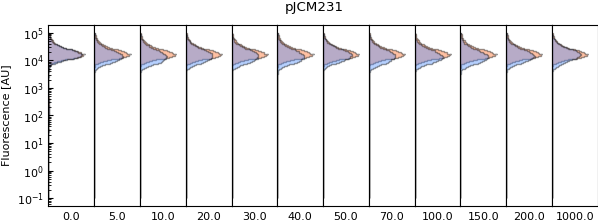

In [38]:
# Visualize consistency of reference promoter
ref_data = data_reference["pJCM434"]
const_data = data_constitutive["J23101-No"]
const_data_AU = const_data["data"]

figsize = (180, 60)

inducer_concentration = ref_data["inducer concentrations"]
output_AU = ref_data["data"]

fig, axes = plt.subplots(ncols=len(inducer_concentration), sharey=True, figsize=mm_to_inch(figsize))
fig.subplots_adjust(wspace=0)

is_first = True
iL = 0

masks = np.array(cur_data["replicates merge info"])
for ax, ind_level, out_levels in zip(axes, inducer_concentration, output_AU):    


    ax.hist(const_data_AU, 
        orientation="horizontal", 
        color=COLORS_MAIN[1], 
        alpha=0.4,
        bins=np.logspace(-1, 5, 200),#histogram_bins, 
        density=hist_as_density,
        histtype="stepfilled",
        ec="k")
    
    ax.hist(out_levels, 
        orientation="horizontal", 
        color=COLORS_MAIN[0], 
        alpha=0.4,
        bins=np.logspace(-1, 5, 200),#histogram_bins, 
        density=hist_as_density,
        histtype="stepfilled",
        ec="k")



    # print(ind_level, np.mean(cur_data[ind_level]))

    if False:
        for iR, replicate_id in enumerate(cur_data["replicates"]):
            replicate_output_AU = cur_data["replicates"][replicate_id]["output"]        
            color = "black" if masks[iL, iR] else COLORS[2]
            ax.hist(replicate_output_AU[iL], 
                    orientation="horizontal", 
                    color=color, 
                    bins=histogram_bins, 
                    density=hist_as_density, 
                    alpha=0.3,
                   histtype="stepfilled",
                   ec="k")    

    xlim = ax.get_xlim()
    ax.set_xlim((xlim[0], xlim[1] * 1.2))
    ax.set_yscale("log")
    # ax.set_title(inducer_concentration)
    ax.set_xticks([])  

    if is_first:
       ax.set_ylabel("Fluorescence [AU]")
       ax.tick_params(axis='y', which='both', direction="in", left=True)            
       is_first = False
    else:
       ax.tick_params(axis='y', which='both', left=False)    
        
    iL += 1
    ax.set_xlabel(f"{ind_level}")# {cur_data['inducer unit']}")
    
plt.suptitle(construct_id)
# plt.savefig(figure_dir + "reference_" + construct_id + "_histograms" + figure_extension)
plt.show()



# Visualize Cross Reactivity

In [39]:
cross_reactivity_keys = list(data_inputs_cross_reactivity.keys())
input_device_keys = set()
inducer_keys = set()
for key in cross_reactivity_keys:
    input_device_key, inducer_key = key.split("-")
    input_device_keys.add(input_device_key)
    inducer_keys.add(inducer_key)

input_device_keys = [elem for elem in input_sensor_order if elem in input_device_keys]
inducer_keys = [elem for elem in inducer_order if elem in inducer_keys]

data = []
for iRow, input_device_key in enumerate(input_device_keys):
    cur_data = []
    for iCols, inducer_key in enumerate(inducer_keys):
        cur_data.append(data_inputs_cross_reactivity[f"{input_device_key}-{inducer_key}"])
    data.append(cur_data)

data = np.array(data)

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

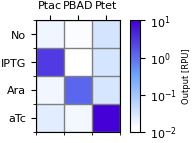

In [40]:
data_to_plot = np.zeros(shape=data.shape)
for iRow in range(data.shape[0]):
    for iCol in range(data.shape[1]):
        data_to_plot[iRow, iCol] = np.median(data[iRow, iCol]["output"])

data_to_plot = data_to_plot.transpose()

fig_size = (60, 42)
fig_size = mm_to_inch(fig_size)
fig, ax = plt.subplots(figsize=fig_size)
im = ax.imshow(data_to_plot, cmap=COLORMAP_BLUE, interpolation="none", origin="upper", rasterized=True, norm=matplotlib.colors.SymLogNorm(linthresh=0.001))


x_ticks = np.arange(data_to_plot.shape[1])
y_ticks = np.arange(data_to_plot.shape[0])
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels(input_device_keys)
ax.set_yticklabels(inducer_keys)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax.set_xticks(np.arange(data_to_plot.shape[1] + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(data_to_plot.shape[0] + 1) - 0.5, minor=True)
ax.grid(which="minor", color="#808080", linestyle='-', linewidth=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size=0.1, pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Output [RPU]", fontsize=6)
cbar.set_ticks([10**(-2), 10**(-1), 10**0, 10**1])
# cbar.set_scale("log")

plt.tight_layout()
plt.savefig(f"{figure_dir}/cross_reactivity{figure_extension}")
plt.show()

## Visualize Inputs

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

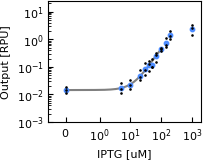

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica


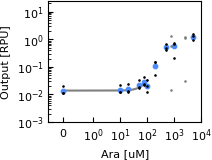

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica


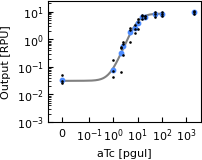

In [41]:
figsize = (50, 40)
linthreshs = [1, 1, 0.1]
for construct_id in data_inputs:
    cur_data = data_inputs[construct_id]
    inducer_concentration = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]
    
    fig, ax = plt.subplots(figsize=mm_to_inch(figsize))


    if "model information" in cur_data:
        params_dict = cur_data["model information"]["parameters"]
        X = histogram_bins
        params = [params_dict[param_id] for param_id in ["y_max", "y_min", "n", "k"]]
        Y_model = activatory_hill_equation(X, params)
        ax.plot(X, Y_model, color="#808080", label="Model", zorder=-5)
        

    
    ax.scatter(inducer_concentration, list(map(np.median, output_RPU)), color=COLORS_MAIN[0], s=10) 
    masks = np.array(cur_data["replicates merge info"], dtype=bool)
    for iR, replicate_id in enumerate(cur_data["replicates"]):
        replicate_output_RPU = cur_data["replicates"][replicate_id]["output"]                
        Y = list(map(np.median, [elem for flag, elem in zip(masks[:, iR], replicate_output_RPU) if flag]))        
        ax.scatter(np.array(inducer_concentration)[masks[:, iR]], Y, color="k", marker=".", s=3) 
        Y = list(map(np.median, [elem for flag, elem in zip(masks[:, iR], replicate_output_RPU) if not flag]))
        ax.scatter(np.array(inducer_concentration)[np.logical_not(masks[:, iR])], Y, color=COLOR_GRAY, marker=".", s=3) 
    # ax.plot(inducer_concentration,  list(map(np.median, output_RPU)), color=COLORS_MAIN[0])


    linthresh = 10**np.floor(np.log10(inducer_concentration[1] / 4))
    
    ax.set_xlim((-linthresh/2, np.max(inducer_concentration) * 2))
    ax.set_ylim((lim[0], 10**1.4))
    ax.set_xlabel(f"{cur_data['inducer molecule']} [{cur_data['inducer unit']}]")
    ax.set_ylabel("Output [RPU]")    
    ax.set_xscale("symlog", linthresh=linthresh)
    ax.set_yscale("log")
    ax.tick_params(axis='both', which='both', direction="in", bottom=True, left=True)
    # ax.set_title(construct_id)

    plt.savefig(figure_dir + "input_" + construct_id + "_response_curve" + figure_extension)

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

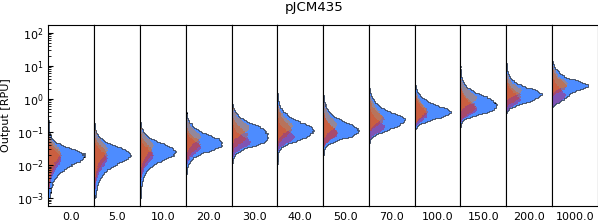

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

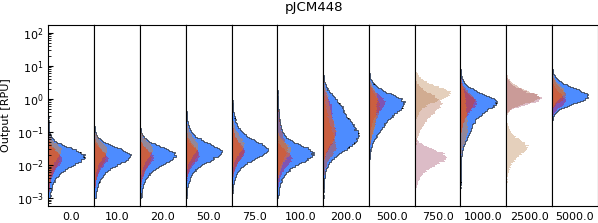

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

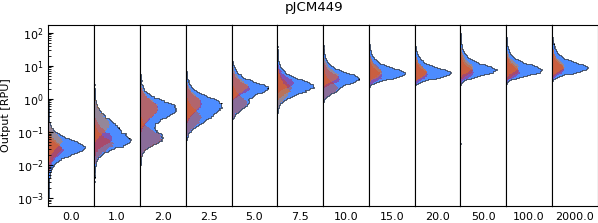

In [42]:
figsize = (180, 60)

cur_colors = ["#EB99B4", "#F5B199", "#FFCC99"]
for construct_id in data_inputs:
    cur_data = data_inputs[construct_id]
    inducer_concentrations = cur_data["inducer concentrations"]
    output_RPU = cur_data["output"]

    fig, axes = plt.subplots(ncols=len(inducer_concentrations), sharey=True, figsize=mm_to_inch(figsize))
    fig.subplots_adjust(wspace=0)

    is_first = True
    iL = 0
    
    masks = np.array(cur_data["replicates merge info"])
    for ax, ind_level, out_levels in zip(axes, inducer_concentrations, output_RPU):    
            
        ax.hist(out_levels, 
                orientation="horizontal", 
                color=COLORS_MAIN[0], 
                bins=histogram_bins, 
                density=hist_as_density,
                histtype="stepfilled",
                linewidth=0.4,
                ec="k")

        for iR, replicate_id in enumerate(cur_data["replicates"]):            
            replicate_output_RPU = cur_data["replicates"][replicate_id]["output"]        
            color = COLOR_REPLICATES[iR]
            alpha = 0.4 if masks[iL, iR] else 0.2
                
            ax.hist(replicate_output_RPU[iL], 
                    orientation="horizontal", 
                    color=color, 
                    bins=histogram_bins, 
                    density=hist_as_density, 
                    alpha=alpha,
                    histtype="stepfilled",
                    linewidth=0.2,
                   )
            if True and not masks[iL, iR]:
                ax.hist(replicate_output_RPU[iL], 
                    orientation="horizontal", 
                    color=COLOR_GRAY,#color, 
                    bins=histogram_bins, 
                    density=hist_as_density, 
                    alpha=0.2,
                    histtype="stepfilled",
                    linewidth=0.2,
                    )    

        xlim = ax.get_xlim()
        ax.set_xlim((xlim[0], xlim[1] * 1.2))
        ax.set_yscale("log")
        # ax.set_title(inducer_concentrations)
        ax.set_xticks([])  

        if is_first:
           ax.set_ylabel("Output [RPU]")
           ax.tick_params(axis='y', which='both', direction="in", left=True)            
           is_first = False
        else:
           ax.tick_params(axis='y', which='both', left=False)    
            
        iL += 1
        ax.set_xlabel(f"{ind_level}")
        
    plt.suptitle(construct_id)
    plt.savefig(figure_dir + "input_" + construct_id + "_histograms" + figure_extension)
    plt.show()

## Visualize Gates

### Visualization of Individual Gates

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

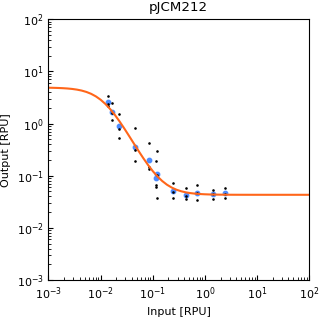

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

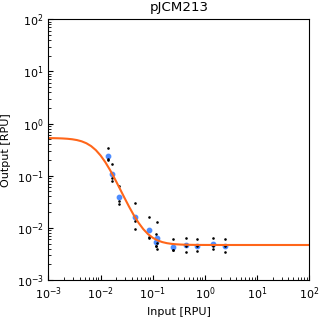

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

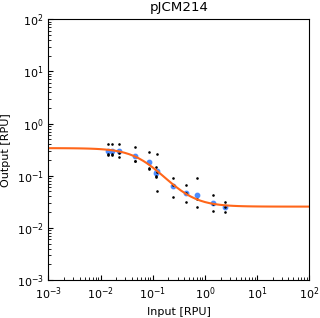

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

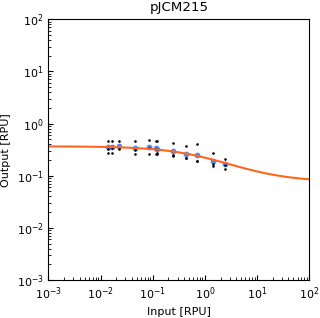

c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families w

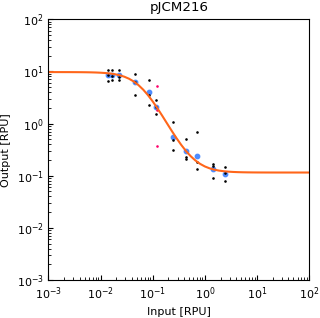

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

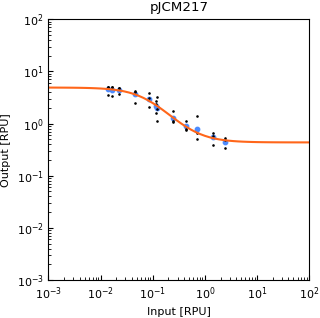

c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families w

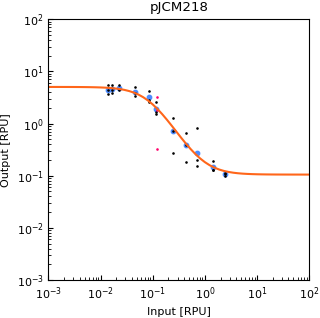

c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families w

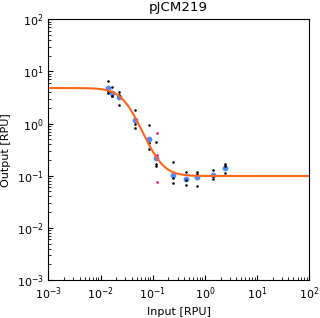

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

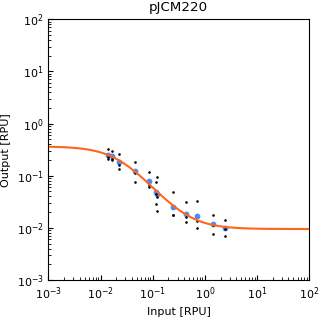

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

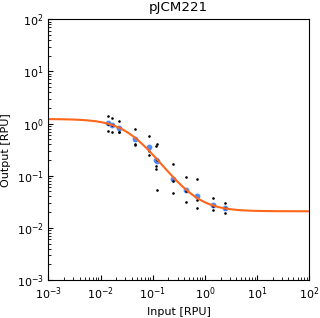

c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families w

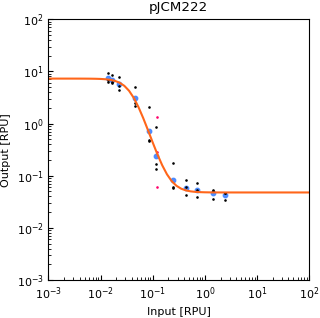

c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families w

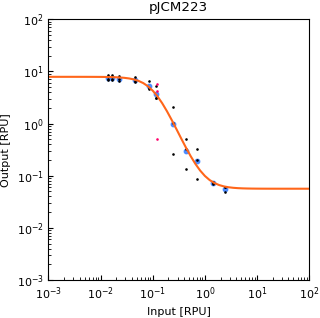

c:\Users\Alexandros\Desktop\CTK-ColiToolKit\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families w

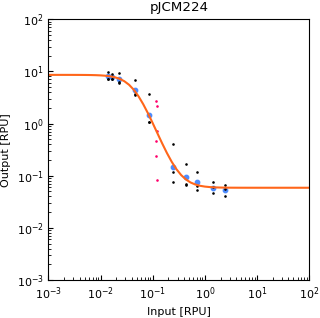

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

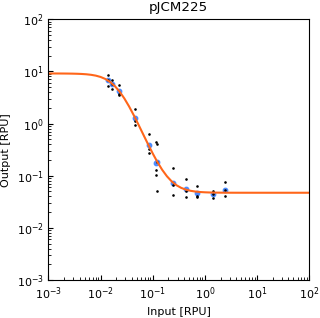

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

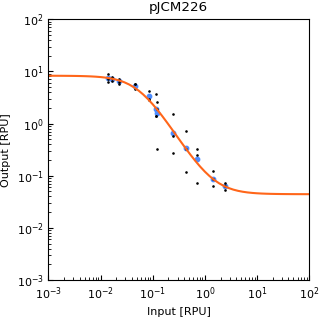

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

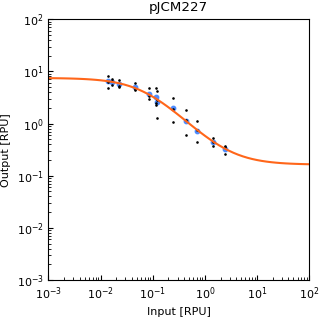

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

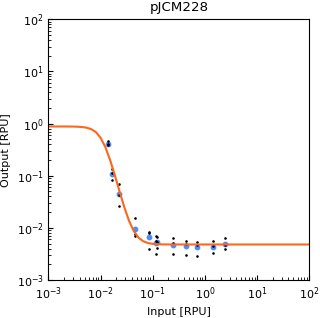

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

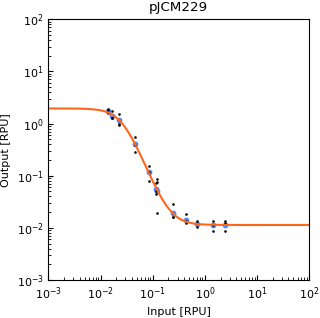

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

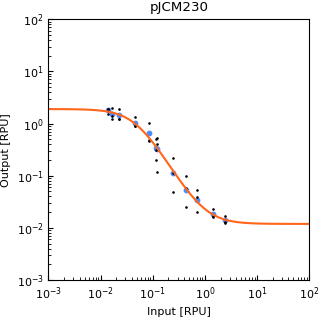

findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'serif' not found because none of the f

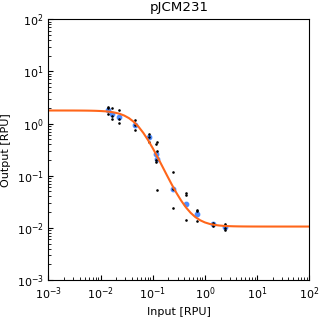

In [43]:
from matplotlib.ticker import AutoMinorLocator

figsize = (48, 50)
figsize = (88, 86)
# figsize = (120, 120)
for construct_id in data_gates:
    cur_data = data_gates[construct_id]
    input_RPU = cur_data["input RPU"]
    output_RPU = cur_data["output"]
    
    
    
    fig, ax = plt.subplots(figsize=mm_to_inch(figsize))
    ax.scatter(input_RPU, list(map(np.median, output_RPU)), color=COLORS_MAIN[0], s=10) 
    # ax.plot(input_RPU,  list(map(np.median, output_RPU)), color=COLORS_MAIN[0])

    if "model information" in cur_data:
        params_dict = cur_data["model information"]["parameters"]
        X = np.logspace(-5, 4, 100)#histogram_bins
        params = [params_dict[param_id] for param_id in ["y_max", "y_min", "n", "k"]]
        Y_model = inhibitory_hill_equation(X, params)
        ax.plot(X, Y_model, color=COLORS_MAIN[1], label="Model")
        

    masks = np.array(cur_data["replicates merge info"], dtype=bool)
    for iR, replicate_id in enumerate(cur_data["replicates"]):
        replicate_output_RPU = cur_data["replicates"][replicate_id]["output"]        
        Y = list(map(np.median, [elem for flag, elem in zip(masks[:, iR], replicate_output_RPU) if flag]))
        ax.scatter(np.array(input_RPU)[masks[:, iR]], Y, color="k", marker=".", s=3) 
        Y = list(map(np.median, [elem for flag, elem in zip(masks[:, iR], replicate_output_RPU) if not flag]))
        ax.scatter(np.array(input_RPU)[np.logical_not(masks[:, iR])], Y, color=COLORS[2], marker=".", s=3)  

    ax.set_xticks([10**(-3), 10**(-1), 10**1])
    ax.set_yticks([10**(-3), 10**(-1), 10**1])    
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_xlabel("Input [RPU]")
    ax.set_ylabel("Output [RPU]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(axis='both', which='both', direction="in", bottom=True, left=True)
    ax.set_box_aspect(1)
    ax.set_title(construct_id)
    plt.savefig(f'{figure_dir}gate_{construct_id}_response_curve_{"-".join(list(map(str,figsize)))}{figure_extension}')
    plt.show()

    

In [44]:
figsize = (48, 50)
# figsize = (88, 86)
# figsize = (100, 50)

for construct_id in data_gates:
    cur_data = data_gates[construct_id]
    inducer_concentrations = cur_data["inducer concentrations"]
    input_RPU = cur_data["input RPU"]
    output_RPU = cur_data["output"]

    fig, axes = plt.subplots(ncols=len(input_RPU), sharey=True, figsize=mm_to_inch(figsize))
    fig.subplots_adjust(wspace=0)


    is_first = True
    iL = 0
    
    masks = np.array(cur_data["replicates merge info"], dtype=bool)
    for ax, ind_level, input_level, out_levels in zip(axes, inducer_concentrations, input_RPU, output_RPU):    
            
        ax.hist(out_levels, 
           orientation="horizontal", 
           color=COLORS_MAIN[0], 
           bins=histogram_bins, 
           density=hist_as_density,
               histtype="stepfilled",
                linewidth=0.4,
               ec="k")

        for iR, replicate_id in enumerate(cur_data["replicates"]):
            replicate_output_RPU = cur_data["replicates"][replicate_id]["output"]        
            color = COLOR_REPLICATES[iR]
            alpha = 0.4 if masks[iL, iR] else 0.2
                
            ax.hist(replicate_output_RPU[iL], 
                    orientation="horizontal", 
                    color=color, 
                    bins=histogram_bins, 
                    density=hist_as_density, 
                    alpha=alpha,
                    histtype="stepfilled",
                    linewidth=0.2,
                   )
            if True and not masks[iL, iR]:
                ax.hist(replicate_output_RPU[iL], 
                    orientation="horizontal", 
                    color=COLOR_GRAY,#color, 
                    bins=histogram_bins, 
                    density=hist_as_density, 
                    alpha=0.2,
                    histtype="stepfilled",
                    linewidth=0.2,
                    )    

        xlim = ax.get_xlim()
        ax.set_xlim((xlim[0], xlim[1] * 1.2))
        ax.set_yscale("log")
        # ax.set_xlabel(f"{int(ind_level)}", fontsize=6)#:.3f}")
        ax.set_xticks([])  

        if is_first:
            ax.set_ylabel("Output [RPU]")
            ax.tick_params(axis='y', which='both', direction="in", left=True)            
            is_first = False
        else:
            ax.tick_params(axis='y', which='both', left=False)            
        iL += 1
            
    plt.suptitle(construct_id)
    plt.savefig(f"{figure_dir}gate_{construct_id}_histograms_{"-".join(list(map(str,figsize)))}{figure_extension}")
    plt.show()

SyntaxError: f-string: expecting '}' (949958082.py, line 70)

### Visualization of Gate Library

In [ ]:
gate_id_median_pairs = [(gate_id, list(map(np.median, data_gates[gate_id]["output"]))) for gate_id in data_gates]
gate_dynamic_ranges = [(elem[0], np.nanmax(elem[1])/np.nanmin(elem[1])) for elem in gate_id_median_pairs]
gate_dynamic_ranges = sorted(gate_dynamic_ranges, key=lambda elem: elem[1], reverse=True)
gate_dynamic_ranges

In [ ]:


figsize = (88, 86)

fig, ax = plt.subplots(figsize=mm_to_inch(figsize))
for iX, gate_tup in enumerate(gate_dynamic_ranges):
    if iX >= present_top_k:
        break
    construct_id, dr = gate_tup
    cur_data = data_gates[construct_id]
    input_RPU = cur_data["input RPU"]
    output_RPU = cur_data["output"]

#    if "model information" in cur_data:
    params_dict = cur_data["model information"]["parameters"]
    X = np.logspace(-5, 4, 100)#histogram_bins
    params = [params_dict[param_id] for param_id in ["y_max", "y_min", "n", "k"]]
    Y_model = inhibitory_hill_equation(X, params)
    ax.plot(X, Y_model, color=COLORS[iX], label=f"{construct_id}")

    
    # ax.scatter(input_RPU, list(map(np.median, output_RPU)), color=COLORS[iX], label=construct_id, s=10) 
    # ax.plot(input_RPU,  
    #         list(map(np.median, output_RPU)), 
    #         ["--", "-.", "--."][iX % 3], 
    #         color=(COLORS + COLORS_DARK)[(iX) % (len(COLORS) + len(COLORS_DARK) - 1)],
    #         label=construct_id)

ax.set_xlabel("Input [RPU]")
ax.set_ylabel("Output [RPU]")
ax.set_xscale("log")
ax.set_yscale("log")            

ax.tick_params(axis='x', which='both', direction="in", left=True)   
ax.tick_params(axis='y', which='both', direction="in", left=True)            
ax.set_box_aspect(1)         

ax.set_xlim(lim)
ax.set_ylim(lim)
        
ax.legend()
plt.savefig(figure_dir +  "gates_all_response_curves" + figure_extension)

### Gate Library Parameters

In [ ]:
table_rep = []

params_order = ["y_max", "y_min", "n", "k"]
header = ["Plasmid", "Gate"] + params_order + ["Dynamic Range"]
table_rep.append(header)

for construct_id in data_inputs:
    cur_data = data_inputs[construct_id]
    
    params_dict = cur_data["model information"]["parameters"]
    params = [params_dict[param_id] for param_id in params_order]        
    
    
    row_vals = [construct_id, ""]
    row_vals += [f"{val:.3f}" for val in params]
    row_vals += [f"{params[0] / params[1] :.3f}"]
    
    table_rep.append(row_vals)
    
    
table_str = "\n".join([", ".join(row) for row in table_rep])
print(table_rep)
with open(f"{figure_dir}/input_hill_parameters.csv", "w") as file:
    file.write(table_str)

In [ ]:
table_rep = []

params_order = ["y_max", "y_min", "n", "k"]
header = ["Plasmid", "Gate"] + params_order + ["Dynamic Range"]
table_rep.append(header)

for construct_id in data_gates:
    cur_data = data_gates[construct_id]
    
    params_dict = cur_data["model information"]["parameters"]
    params = [params_dict[param_id] for param_id in params_order]        
    
    
    row_vals = [construct_id, ""]
    row_vals += [f"{val:.3f}" for val in params]
    row_vals += [f"{params[0] / params[1] :.3f}"]
    
    table_rep.append(row_vals)
    
    
table_str = "\n".join([", ".join(row) for row in table_rep])
print(table_rep)
with open(f"{figure_dir}/gate_parameters.csv", "w") as file:
    file.write(table_str)